<!-- <img src="https://data.atoti.io/notebooks/covid-analytics/img/banner.jpg"> -->

# Atoti Masterclass: Atoti and Excel  

## Objective
We will be exploring how to use **Atoti** via an exploration of [Budget and Expenses data](https://data.atoti.io/notebooks/excel-and-atoti/Monthly_Budget_template.xlsx).  Our main focus will be on translating the excel template in Atoti and how one can connect MS Excel to Atoti.  

<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/excel_to_atoti.png" width="60%"/>

### This guide will cover the following:

1. Translating an Excel Workbook in Atoti.
2. Performing Scenario Simulations on budget reduction.
3. Connecting Excel to the Atoti Cube.
4. Updating a dashboard in Atoti in real-time, based on changes in underlying CSV file.

### We will use this notebook in two ways: 

1. We combine tables from 3 of the pages in the template into the [budget.csv](https://data.atoti.io/notebooks/excel-and-atoti/budget.csv) to be loaded into Atoti.  
2. We extended the data from config 1 to include a `date period` where we can have randomized budgets for multiple months and then.  

### What it won't cover:

This notebook is created with an assumption that the user is familiar with the basics of Atoti.

As a result, we will not cover the following:

* [How to install Atoti](https://docs.atoti.io/latest/getting_started/installation.html)
* [Creating and manipulating hierarchies and levels](https://docs.atoti.io/latest/api/atoti.Level.html#atoti.Level)
* [Creating aggregations](https://docs.atoti.io/latest/api/atoti.agg.html)

You can always checkout our previous [masterclasses](https://www.youtube.com/c/atoti/videos?view=2&live_view=503) for the above topics and much more!

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=excel-and-atoti" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

## Getting Started

In [1]:
import atoti as tt

## Two ways to try out this notebook

In this notebook, we will attempt two different configurations:  

1. We combine tables from 3 of the pages in the template into the [budget.csv](https://data.atoti.io/notebooks/excel-and-atoti/budget.csv) to be loaded into Atoti.  
2. We extended the data from config 1 to include a `date period` where we can have randomized budgets for multiple months.  

These 'configurations' are a reflection of how Atoti can adapt to the changes in underlying data and hence updating the widgets and dashboard accordingly. 


In the default configuration where we will use config 1 above to create Atoti as close to the spreadsheet as possible, we set the variable `extended` to `False`. If you would like to try out configuration 2, where we can use the same dashboard to view the budget for different months, set the variable `extended` to `True`.

In [2]:
extended = False

Below are some of the variables that will change, according to the configurations chosen.

In [3]:
original_data = "s3://data.atoti.io/notebooks/excel-and-atoti/budget.csv"
extended_date = "s3://data.atoti.io/notebooks/excel-and-atoti/semi-annual-budget.csv"

content_server = "./content"
extended_content = "./content2"

tbl_keys = []
extended_tbl_keys = ["PERIOD", "BUDGET_TYPE", "BUDGET_SUBTYPE", "CATEGORY"]

In [4]:
content_path = extended_content if extended else content_server
data_path = extended_date if extended else original_data
keys = extended_tbl_keys if extended else tbl_keys

## Create Atoti cube

In [5]:
session = tt.Session.start(tt.SessionConfig(user_content_storage=content_path))

Take note that in the default configuration, we do not set keys for the table. This means that we will not check for duplicates in the data. In the extended configuration, we will set keys for the table. This has the following advantages: 

- Prevents duplication on the key columns (the latest data will overwrite the existing record in the table)
- Key columns will be dictionarized and queries will be more effective! Especially so if we set up [partitions](https://docs.atoti.io/latest/api/atoti.Session.create_table.html#atoti.Session.create_table).

In [6]:
budget_tbl = session.read_csv(
    data_path,
    keys=keys,
    table_name="Budget",
)
budget_tbl.head()

,BUDGET_TYPE,BUDGET_SUBTYPE,CATEGORY,ESTIMATED,ACTUAL
0,Income,Income,Net sales,60000,54000
1,Income,Income,Interest income,3000,3000
2,Expenses,Operating,Telephone,250,280
3,Income,Income,Asset sales (gain/loss),300,450
4,Expenses,Operating,Interest,2000,2200


In [7]:
budget_tbl.row_count

26

In [8]:
cube = session.create_cube(budget_tbl, "budget")

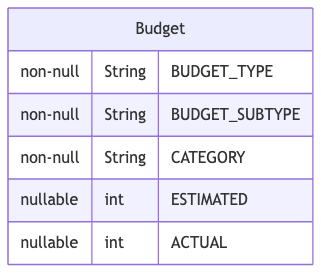

In [9]:
session.tables.schema

## Visualization - Budget Overview  

We can replicate similar Budget Overview right off the bat with the [measures created automatically during cube creation](https://docs.atoti.io/latest/api/atoti.Session.create_cube.html#atoti.Session.create_cube).  

<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/budget_overview.png" width="500px"/>

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
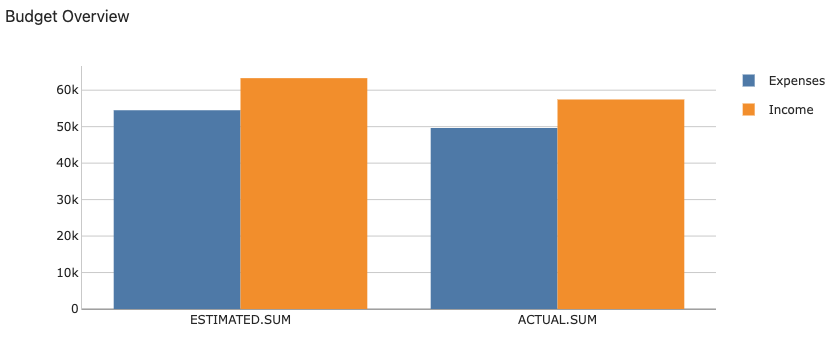

In [10]:
session.widget

## Visualization - Monthly Budget  

Let's explore the cube to see how far off are we from the Excel's Monthly budget table:  

<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/monthly_budget.png" />

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
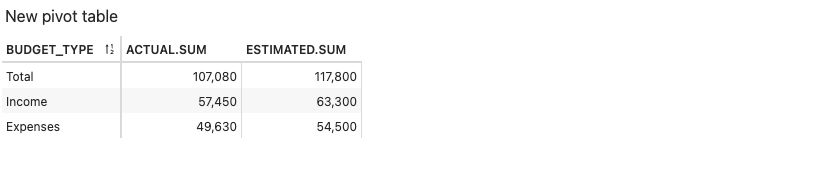

In [11]:
session.widget

We need to tackle the below if we want to achieve the same table as in the Excel template.  
1. The order of the BUDGET TOTALS should be (Income, Expenses).
2. Total should be the difference between _Income_ and _Expenses_ instead of a summation between the two.
3. We need to create a measure that computes the difference between the _Estimated_ and _Actual_.

### Attributes of a cube  

Before we proceed to handle the above mentioned, let's create alias for our cube attributes to make our coding easier.

In [12]:
cube

In [13]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

## Sorting Budget type

We can sort the _Budget_Type_ by doing a right-click on its header and sort in ascending order. 

<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/sorting.gif" />

Alternatively, we can hardcode the default order by sort the level using [`CustomOrder`](https://docs.atoti.io/latest/api/atoti.CustomOrder.html#atoti.CustomOrder). In our case, we will use CustomOrder and `first_elements` to fix the order to ("Income", "Expenses").

In [14]:
l["BUDGET_TYPE"].order = tt.CustomOrder(first_elements=["Income", "Expenses"])

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
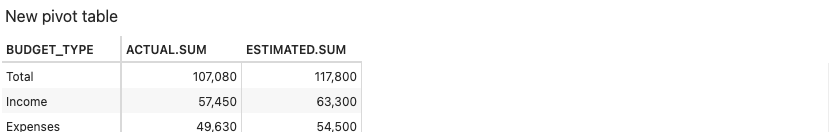

In [15]:
session.widget

## Aggregation - Computing the Total value

Since the default behaviour of `ACTUAL.SUM`/`ESTIMATED.SUM` to add up the value of `ACTUAL`/`ESTIMATED`, let's negate the values of expenses since they are outgoing values. To do this, let's create new measures with conditional values using [`atoti.where`](https://docs.atoti.io/latest/api/atoti.where.html#atoti.where).

In [16]:
m["Estimated"] = tt.agg.sum(
    tt.where(
        l["BUDGET_TYPE"] == "Expenses", (-1 * m["ESTIMATED.SUM"]), m["ESTIMATED.SUM"]
    ),
    scope=tt.OriginScope(levels={l["BUDGET_TYPE"]}),
)
m["Actual"] = tt.agg.sum(
    tt.where(l["BUDGET_TYPE"] == "Expenses", (-1 * m["ACTUAL.SUM"]), m["ACTUAL.SUM"]),
    scope=tt.OriginScope(levels={l["BUDGET_TYPE"]}),
)

We can even drill-down to the subtype to see the estimated and actual budgets in two ways:

1. Adding `BUDGET_SUBTYPE` to the rows section to get it expanded for all the `BUDGET_TYPE`
2. Drag and drop the `BUDGET_SUBTYPE` on a member of `BUDGET_TYPE` in the pivot table. This will return a collapsible level as shown below:

<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/collapsible_pivot.gif" width="60%" />

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
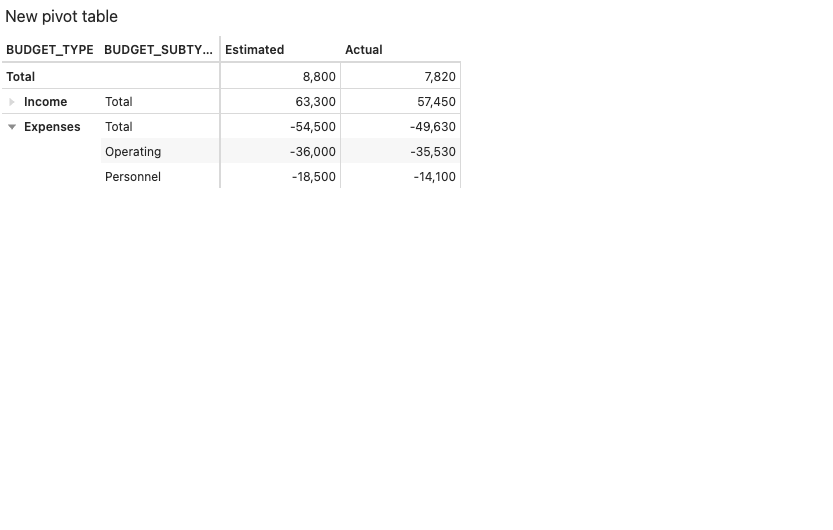

In [17]:
# Add in BUDGET_SUBTYPE to drill-down on the sub-levels
session.widget

## Aggregation - Computing the Difference  

In [18]:
m["Difference"] = m["Actual"] - m["Estimated"]

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
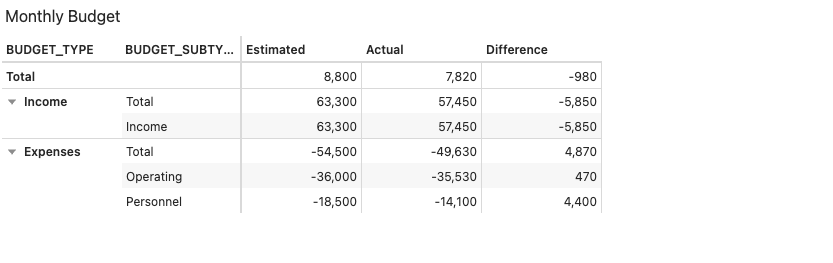

In [19]:
session.widget

### Formatting  

This is not necessary but if you prefer round brackets to the minus sign, we can format the measures as follows:

In [20]:
m["Estimated"].formatter = "DOUBLE[$#,##0;($#,##0)]"
m["Actual"].formatter = "DOUBLE[$#,##0;($#,##0)]"
m["Difference"].formatter = "DOUBLE[$#,##0;($#,##0)]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
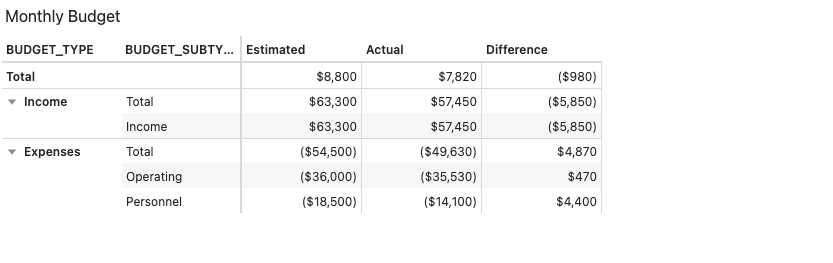

In [21]:
session.widget

## Top 5 Categories in Operating expenses

We can apply filter interactively on the Pivot widget using the Atoti editor.

<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/filter.png" width="50%" />

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
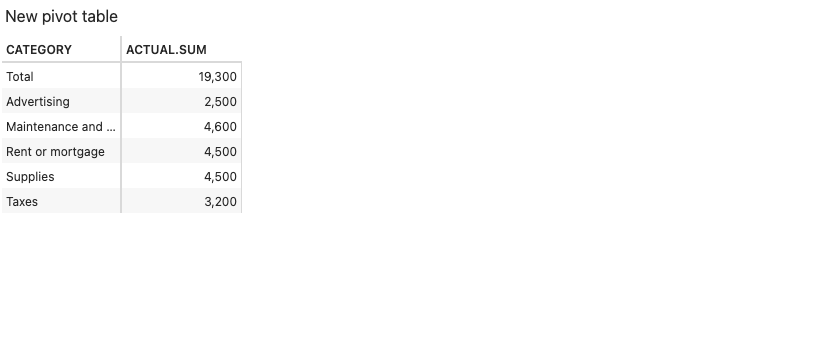

In [22]:
session.widget

Instead of looking at the top 5 categories only in Operating expenses, we can look at top 5 categories in each budget subtype! Let's do so by creating a multi-level hierarchy.

In [23]:
h["Budget Category"] = [l["BUDGET_TYPE"], l["BUDGET_SUBTYPE"], l["CATEGORY"]]

Let's do this interactively via the advanced filtering in Atoti editor:  
<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/advanced_filter.gif" width="65%" />

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
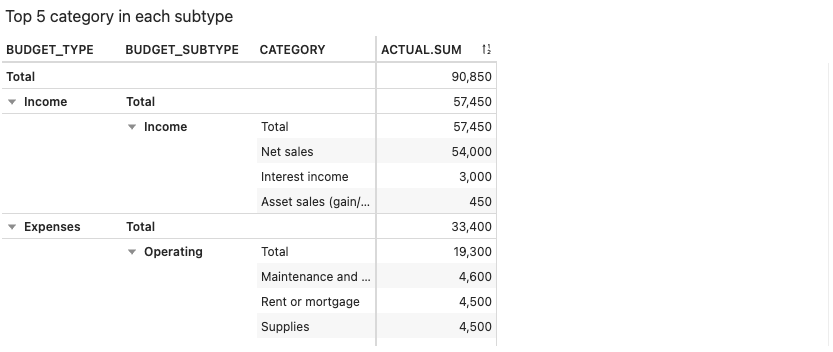

In [24]:
session.widget

In [25]:
m["Budget type total"] = tt.parent_value(
    m["ACTUAL.SUM"], degrees={h["Budget Category"]: 2}
)

The pivot below is reflecting only the top 5 (or less) categories in each budget subtype and the `ACTUAL.SUM` is reflected accordingly. However, when computing [`atoti.parent_value`](https://docs.atoti.io/latest/api/atoti.parent_value.html#atoti.parent_value), it takes into consideration the total for all members (not the top 5). Therefore, `Budget type total` is showing 49,630 at the category level instead of `33,400` which is the total value of `ACTUAL.SUM` 2 levels (or degrees) up from itself.

To apply the widget filter on the `parent_value`, we can set the `apply_filters` parameter to `True`:

```python
m["Budget type total"] = tt.parent_value(
    m["ACTUAL.SUM"], degrees={h["Budget Category"]: 2}, apply_filters=True
)
```

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
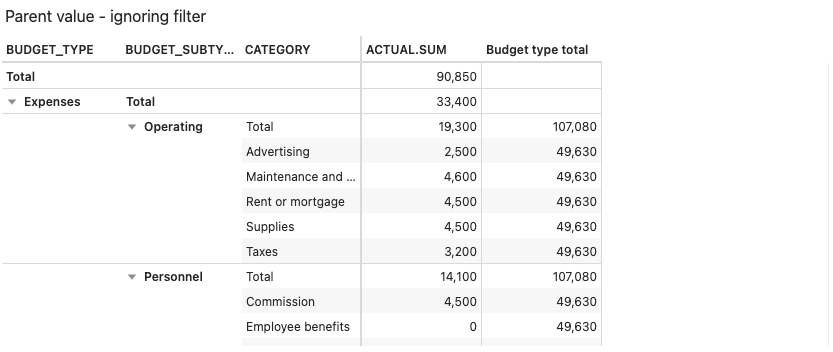

In [26]:
session.widget

### To apply aggregation on formula or not?

We saw earlier on that formulae in Atoti is as straightforward as `m["Difference"] = m["Actual"] - m["Estimated"]`. But things can get more interesting than that. Let's first try to apply the formula as it is.

In [27]:
# Compare measures without aggregation on the given scope
m["_% of Budget"] = m["ACTUAL.SUM"] / m["Budget type total"]
m["_% of Budget"].formatter = "DOUBLE[0.00%]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
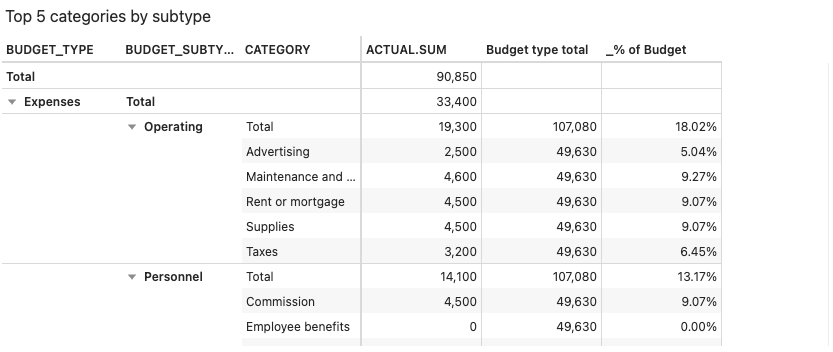

In [28]:
session.widget

Looking at the table above, the percentage at the `BUDGET_SUBTYPE` levels is against the total Income + Expenses (107,080), without consideration of incoming or outgoing. The purpose of `% OF EXPENSES` in the spreadsheet computes the expense at `CATEGORY` level as a percentage to the total at the `BUDGET_SUBTYPE` level. E.g. for Top 5 Operating expenses, it would be `19,300 / 49,630 = 0.389`.

Let's see what happens when we apply the formula only at the `CATEGORY` level (via the scope) and then apply summation to the levels above the `CATEGORY` level.

In [29]:
m["% of Budget"] = tt.agg.sum(
    m["ACTUAL.SUM"] / m["Budget type total"],
    scope=tt.OriginScope(levels={cube.levels["Budget", "Budget Category", "CATEGORY"]}),
)

m["% of Budget"].formatter = "DOUBLE[0.00%]"

Does it make sense to sum up the percentage? Yes, when we sum up the `m["% of Budget"]` for the displayed categories, it gives the % of budget these top 5 categories make up for the Budget type.  

E.g. The top 5 Operating expenses makes up 38.39% of the total expenses. The top 5 Operating expenses and top 5 (or 3 in this case) Personnel expenses makes up 67.3% of the total expenses.  

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
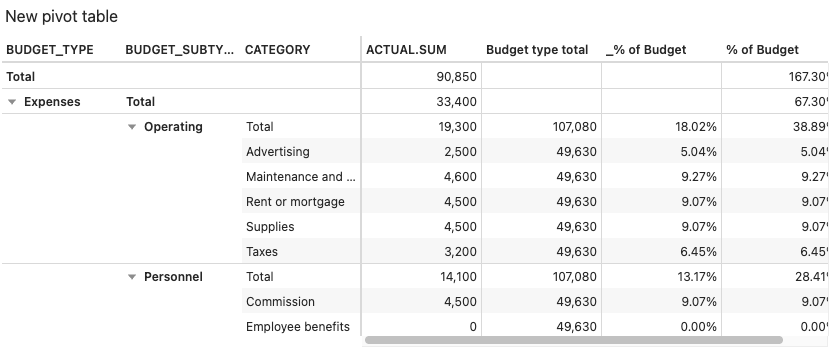

In [30]:
session.widget

What doesn't make sense is the Grand Total of 167.3% (we cannot simply sum up `Income` and `Expenses`). We can hide the Grand Total for _this particular widget_ from its context menu as shown below.

<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/hide_grandtotal.gif" width="65%"/>  

💡 **Note:** The above will hide the Grand Total for all the measures in the columns.

Alternatively, we can do a more definitive hide by applying a `where` condition in `m["% of Budget"]` to return `None` value when there is no `BUDGET_TYPE` member. This will be applicable for _all use of the measure_.

In [31]:
m["% of Budget"] = tt.where(
    ~cube.levels["Budget", "Budget Category", "BUDGET_TYPE"].isnull(),
    tt.agg.sum(
        m["ACTUAL.SUM"] / m["Budget type total"],
        scope=tt.OriginScope(
            levels={cube.levels["Budget", "Budget Category", "CATEGORY"]}
        ),
    ),
)

# reapply formatting whenever the measure definition is updated
m["% of Budget"].formatter = "DOUBLE[0.00%]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
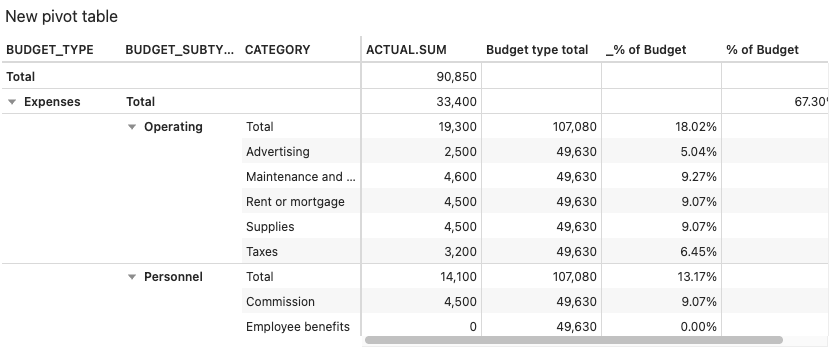

In [32]:
session.widget

### 15% reduction

In the Excel, there is a column which takes 15% of the `ACTUAL` amount. We can have a similar measure for that.

In [33]:
m["15% reduction"] = m["ACTUAL.SUM"] * 0.15

Taking that one step further, we could actually create the percentage reduce as a parameter measure to enable simulation. By default, there's zero reduction.

In [34]:
reduction_simulation = cube.create_parameter_simulation(
    "Reduction simulation",
    measures={"% reduction": 0.0},
    levels=[cube.levels["Budget", "Budget Category", "CATEGORY"]],
)

We can compute the amount reduced simply by multiplying the `ACTUAL` amount by the parameter measure `% reduction`.

In [35]:
m["Reduction"] = m["ACTUAL.SUM"] * m["% reduction"]

Ready to run some simulations? Let's reduce the amount by 15% and 20% and label the scenarios accordingly.

In [36]:
reduction_simulation += ("15%", None, 0.15)
reduction_simulation += ("20%", None, 0.20)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
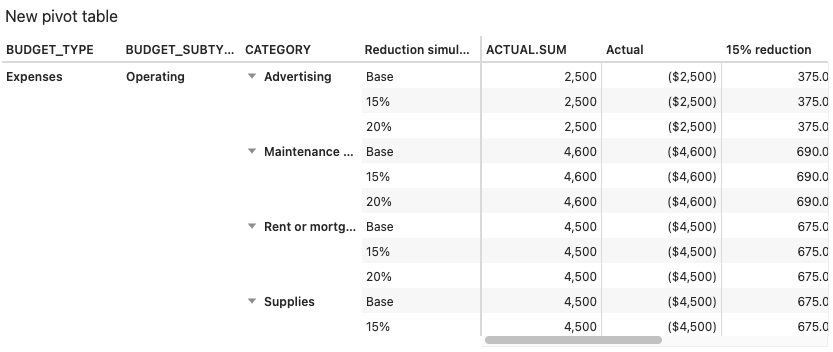

In [37]:
session.widget

In [38]:
_initial_actual = tt.where(
    cube.levels["Budget", "Budget Category", "BUDGET_TYPE"] == "Expenses",
    (-1 * m["ACTUAL.SUM"]),
    m["ACTUAL.SUM"],
)

m["Actual"] = tt.agg.sum(
    _initial_actual * (1 - m["% reduction"]),
    scope=tt.OriginScope(
        levels={cube.levels["Budget", "Budget Category", "BUDGET_TYPE"]}
    ),
)

m["Actual"].formatter = "DOUBLE[$#,##0;($#,##0)]"

We can see what the `ACTUAL` amount becomes after reduction, simply by updating its definition. We can see below, we incorporated `1 - m["% reduction"]` into the formula below. Running the same visualization as the previous one, we can see how the `Actual` changed from the `ACTUAL.SUM` (we applied the reduction on `Actual` instead of `ACTUAL.SUM` just to show the difference).

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
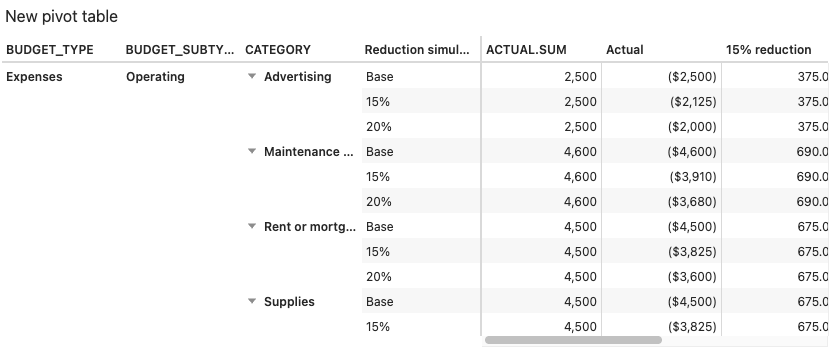

In [39]:
session.widget

### Connecting Excel to Atoti cube  

The below URL gives access to the Atoti UI.

In [40]:
session.link

http://localhost:55617

Access pre-saved dashboard.

In [41]:
session.link / "#/dashboard/869"

http://localhost:55617/#/dashboard/869

Use the below link to connect from Excel to Atoti. Refer to __[Atoti documentation](https://docs.atoti.io/latest/how_tos/connect_with_excel.html)__ for the steps.

In [42]:
session.link / "xmla"

http://localhost:55617/xmla

<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/connecting_from_excel.gif" width="60%" />

## Bonus on extended data

Access the below dashboard if `extended=True`. We can have real-time monitoring from the dashboard.

In [43]:
session.link / "#/dashboard/2ca"

http://localhost:55617/#/dashboard/2ca

We can add the quick filter to toggle between different month's budget within the same dashboard.  

<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/quick_filter.gif" width="50%"/>

### Maintaining a single data file with real-time data loading

The advantage of the extended configuration is that only 1 data file is involved across the months. We can set up a file monitoring service as shown in the cell below. This will allow users to update a single file with future budgets and getting them uploaded to Atoti upon saving.  

In the example below, we monitor the data folder for incoming files. So it's really up to users if they want to maintain a single data file or multiple. However, do ensure the data structure is consistent through all the data files.

In [44]:
from watchdog.events import FileCreatedEvent, FileSystemEventHandler
from watchdog.observers.polling import PollingObserver


class AtotiWatcher(FileSystemEventHandler):
    def on_created(self, event: FileCreatedEvent):
        try:
            print("File modified/created", event.src_path)
            budget_tbl.load_csv(event.src_path)
            print("Loading completed", event.src_path)
        except Exception as error:
            print(error)


observer = PollingObserver()
observer.schedule(AtotiWatcher(), "data")
observer.start()

Make some modification to the `.data/semi-annual-budget.csv` file. Re-run the query below to see new the newly added data. The measures automatically computes the updated values based on the new data.

In [45]:
m["Difference"] = m["Actual"] - m["Estimated"]
m["Estimated"].formatter = "DOUBLE[$#,##0;($#,##0)]"
m["Actual"].formatter = "DOUBLE[$#,##0;($#,##0)]"
m["Difference"].formatter = "DOUBLE[$#,##0;($#,##0)]"

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
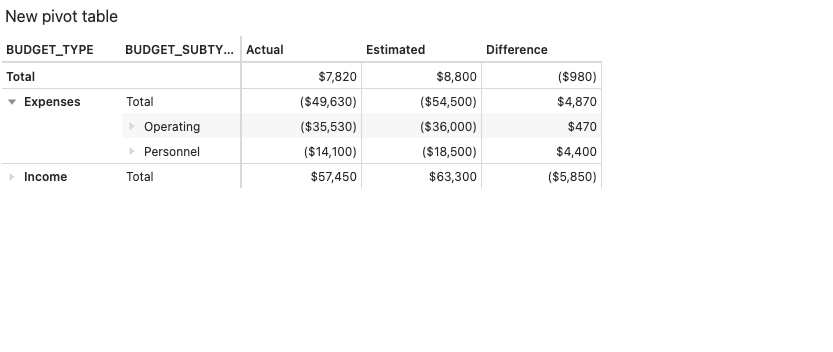

In [46]:
session.widget

### Real-time dashboarding

We can set the widgets in dashboard to [real-time mode](https://activeviam.com/activeui/documentation/5.0.6/docs/user-guides/real-time-updates). As watchdog picks up the modification and loads data into Atoti, we will see the changes reflected real-time.  

<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/realtime.gif" width="60%" />  

Run the below command to stop the monitoring.

In [47]:
observer.stop()
observer.join()

# Recap 

#### 1. Creating, Filtering, and Sorting Visualisations in Atoti 
<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/sorting.gif" />

#### 2. Connecting Excel with Atoti
<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/connecting_from_excel.gif" width="60%" />


#### 3. Real-time dashboarding

We can set the widgets in dashboard to [real-time mode](https://activeviam.com/activeui/documentation/5.0.6/docs/user-guides/real-time-updates).  
As watchdog picks up the modification and loads data into Atoti, we will see the changes reflected real-time.  
<img src="https://data.atoti.io/notebooks/excel-and-atoti/img/realtime.gif" width="60%" />  



## Follow us on 

### <img src="https://data.atoti.io/notebooks/covid-analytics/img/linkedin.png" width = "20px"> LinkedIn https://www.linkedin.com/showcase/atoti  
### <img src="https://data.atoti.io/notebooks/covid-analytics/img/twitter.png" width = "20px"> Twitter   https://twitter.com/atoti_io  
### <img src="https://data.atoti.io/notebooks/covid-analytics/img/youtube.png" width = "20px"> YouTube  https://www.youtube.com/c/atoti  
### <img src="https://data.atoti.io/notebooks/covid-analytics/img/medium.png" width = "20px"> Medium   https://medium.com/atoti  


## For more information

### <img src="https://data.atoti.io/notebooks/covid-analytics/img/atoti.png" width = "20px"> Go to https://www.atoti.io to subscribe to our newsletter for the latest information sharing.

<div style="text-align: center;"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=excel-and-atoti" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>